# Classificação binária com Redes Neurais Quânticas: Teoria e Prática

## Introdução

No artigo é demonstrado que circuitos quânticos com estrutura hierárquica podem ser usados para classificar estados quânticos altamente emaranhados, para os quais não há método clássico eficiente conhecido.

As redes tensoriais com estrutura hierárquica exibem muitas semelhanças com as redes neurais e, em alguns casos, mostraram-se equivalentes. Dado que as redes tensoriais podem ser usadas para representar redes neurais e circuitos quânticos, elas são uma escolha natural para explorar a interseção dos dois campos.

Para executar a classificação em um computador quântico, os dados de entrada devem ser codificados em um estado quântico. Duas maneiras pelas quais isso pode ser alcançado são pela codificação dos dados nas amplitudes de qubits individuais em um estado totalmente separável (qubit encoding) ou nas amplitudes de um estado emaranhado (amplitude encoding). Para dados quânticos, assume-se que chegam de outro dispositivo quântico já em amplitude encoding.

O classificador consiste em uma série de operações unitárias aplicadas ao estado quântico inicial. Em seguida, é realizada uma medição em um qubit alvo. Na prática, são necessárias várias execuções para aproximar a expectativa do resultado da medição, e o resultado mais frequente é tomado como a classe prevista.

Os circuitos usados são do tipo árvore e podem ser parametrizados com um simples conjunto de portas compatível com os computadores quânticos atualmente disponíveis. O primeiro desses circuitos é conhecido como tree tensor network (TTN). Em seguida, consideramos um layout de circuito mais complexo conhecido como multi-scale entanglement
renormalization ansatz (MERA). Os MERAs são semelhantes aos TTNs, mas fazem uso de transformações unitárias adicionais para capturar efetivamente uma ampla gama de correlações quânticas.

Os classificadores são construídos utilizando três técnicas diferentes. A primeira delas usa apenas rotações de um qubit e portas CNOT fixas. A segunda usa portas mais gerais de dois qubits. A terceira usa portas de três qubit, onde as ancillas adicionais permitem operações não lineares.

São comparados o desempenho de várias parametrizações diferentes - reais e complexas - em dois conjuntos de dados clássicos de aprendizado de máquina, Iris e MNIST, e em um conjunto de dados sintético de estados quânticos.

O trabalho é concluído demonstrando que o desempenho é robusto ao ruído e implementando um classificador sobre conjunto de dados Iris no computador quântico ibmqx4.

## Codificação de Dados

Vamos primeiro considerar o caso dos dados clássicos. Um conjunto de dados clássico para classificação binária é um conjunto

$\mathcal{D} = \{(\boldsymbol{x}^{d}, y^d) \}_{d = 1}^D$, 

em que $\boldsymbol{x}^{d} \in \mathbb{R}^N$ são vetores de entrada $N$-dimensionais e $y^{d} \in \{0, 1\}$ são os rótulos de classe correspondentes.

A classificação de dados clássicos em um computador quântico exige que os vetores de entrada sejam codificados em um estado quântico. Existem várias maneiras de conseguir isso e algoritmos diferentes exigem métodos de codificação diferentes.

A abordagem mais eficiente em termos de espaço é codificar dados clássicos nas amplitudes de uma superposição, ou seja, usar $N$ qubits para codificar um vetor de dados dimensionais $2^{N}$. No entanto, no caso geral e dependendo do classificador quântico usado, o custo computacional da preparação dos dados como uma superposição pode negar a aceleração obtida durante a classificação.

Um método mais simples é codificar cada elemento de um vetor de dados clássico na amplitude de um único qubit. Esse tipo de codificação requer que $N$ qubits codifiquem um vetor de dados $N$-dimensional e, portanto, é menos eficiente em termos de espaço. No entanto, a preparação do estado é claramente eficiente em termos de tempo, pois requer apenas rotações de um qubit único. Optamos por esse tipo de codificação para dados clássicos. Em particular, primeiro redimensionamos os vetores de dados em elementos no intervalo $[0, \frac{\pi}{2}]$. Em seguida, codificamos cada elemento do vetor em um qubit usando o seguinte esquema:

$
\psi_{n}^d = \cos(x_{n}^d) |0\rangle + \sin(x_{n}^d) |1\rangle.
$

O vetor de dados final é escrito como $\psi^d = \otimes_{n = 1}^N \psi_n^d$ e está pronto para ser usado em um algoritmo quântico.

Vamos agora considerar o caso dos dados quânticos. Um conjunto de dados quânticos para classificação binária é um conjunto 

$\mathcal{D} = \{ \psi^{d}, y^d) \}_{d = 1}^D$, 

em que $\psi^{d} \in \mathbb{C}^{2^N}$ são vetores de entrada $2^N$-dimensionais de comprimento unitário e $y^{d} \in \{0, 1\}$ são as classes correspondentes. Ao contrário dos dados clássicos, dados quânticos, como a saída de um circuito quântico ou um sensor quântico, já podem estar em superposição. Ou seja, os estados quânticos são usados como estão e não há custo relevante para a preparação.

In [ ]:
def qubit_encoding(circuit, q, classical_data):
    for i in range(len(classical_data)):
        circuit.ry((2*classical_data[i]-1)*m.pi, q[i])

def amplitude_encoding(circuit, q, classical_data):
    data = (2*classical_data-1)
    desired_vector = data+[0]*(2**len(q)-len(classical_data))
    desired_vector = desired_vector / np.linalg.norm(desired_vector)
    
    circuit.initialize(desired_vector, q)

## Arquitetura de Circuitos

Discutimos agora as arquiteturas de circuitos quânticos para classificação. A primeira arquitetura de circuito é inspirada em redes tensoras de árvores, especificamente em árvores binárias. O circuito TTN começa aplicando um conjunto de unidades vizinhas mais próximas de dois qubit à entrada. Em seguida, descartamos um dos qubits de saída de cada unidade, reduzindo pela metade o número de qubits na próxima camada do circuito. Na camada a seguir, aplicamos novamente os unitários de dois qubit aos qubits restantes antes de descartar metade deles. Esse processo é repetido até restar apenas um qubit. A rede na íntegra consiste em medir um valor esperado de qubit único nesse qubit restante

$
M_{\boldsymbol{\theta}}(\psi^d) = \langle \psi^d | \hat{U}_{QC}^\dagger (\{U_i(\theta_i) \}) \hat{M} \hat{U}_{QC} (\{U_i(\theta_i) \}) | \psi^d \rangle,
$

onde $\hat{U}_{QC} (\{U_i \})$ é o circuito quântico composto pelos operadores unitários $U_i(\theta_i)$, $\boldsymbol{\theta} = \{\theta_i \}$ é o conjunto de parâmetros que definem os operadores e $\hat{M}$ é o operador de qubit único cujo valor esperado estamos calculando. Um diagrama de circuito de um TTN de 8 qubits é mostrado abaixo. As linhas sólidas abrangem o circuito, enquanto as linhas tracejadas representam seu transposto conjugado.

<img src="https://raw.githubusercontent.com/israelferrazaraujo/comp-quantica/patch-3/projetos/2019-01/files/QuantumTTN.png" style="width:50%">

A rede MERA está intimamente relacionada ao TTN. Todos os operadores que compõem a rede em árvore são mantidos com uma camada adicional de operadores de dois qubits adicionados antes de cada camada do TTN. Esses operadores adicionais, $\{D_i \}$, atuam em um qubit de cada um dos operadores vizinhos na próxima camada TTN. Em uma rede MERA convencional, a adição desses unitários permite que correlações quânticas em uma determinada escala de comprimento sejam capturadas na mesma camada da rede. Um diagrama de circuito de um MERA de 8 qubit é mostrado abaixo.

<img src="https://raw.githubusercontent.com/israelferrazaraujo/comp-quantica/patch-3/projetos/2019-01/files/QuantumMERA.png" style="width:50%">


In [ ]:
def mry(circuit, q, params):
    '''
    mry = Multiple RY.
    Aplica a porta RY num conjunto de qubits e os conecta usando CNOT.
    '''
    n = len(q)
    i = 0
    while i < n:
        circuit.ry(params[i], q[i])
        i += 1
        if i < n:
            circuit.ry(params[i], q[i])
            circuit.cx(q[i], q[i-1])
            i += 1

## Parametrização

Foram exploradas três maneiras diferentes de parametrizar os operadores usados nesses circuitos. Alguns dos dados de entrada usados são puramente reais; portanto, testou-se o efeito de restringir os unitários a serem reais também. Ou seja, escolheram-se operadores de forma que $U_i \in SO(\cdot) \subset SU(\cdot)$. Também considerou-se operadores gerais de valor complexo $U_i \in SU(\cdot)$. Como foi observado no contexto do princípio variacional dependente do tempo aplicado às redes tensoriais, o uso de pesos complexos geralmente impede que a otimização fique presa nos mínimos locais.

Também explorou-se vários outros métodos para parametrizar os operadores; A figura abaixo ilustra três dessas paramaterizações. Na figura (a), o bloco unitário é composto por duas rotações arbitrárias de qubit único e uma porta CNOT$_{ij}$, onde $i$ e $j$ são qubits de controle e alvo, respectivamente. No caso da restrição a $SO(4)$, as rotações de um qubit único são simplesmente rotações $Y$.

<img src="https://raw.githubusercontent.com/israelferrazaraujo/comp-quantica/patch-3/projetos/2019-01/files/Unitarys2qubit.png" style="width:50%">

Na figura (b), o bloco unitário consiste em uma porta arbitrária de dois qubits. É interessante explorar essa configuração muito mais geral em simulações, embora uma implementação prática dessa unidade possa ser custosa. Ou seja, o operador de dois qubit precisa ser compilado em portas de baixo nível, dependentes do hardware.

Finalmente, a figura (c) mostra uma porta de três qubits envolvendo um qubit ancilla. Ao executarmos um traço parcial no qubit ancilla, podemos implementar efetivamente uma rica classe de funções não lineares, por exemplo as funções escada, assemelhando-se muito às operações das redes neurais clássicas. Novamente, na prática, uma sobrecarga significativa é esperada devido à compilação.

A medição $\hat{M}$ é realizada em um qubit específico e consiste em uma simples medição de Pauli na direção escolhida. Isso pode ser implementado na prática por uma rotação adicional de qubit único seguida pela medição projetiva em $|0\rangle \langle0|$. Isso é suficiente para uma tarefa de classificação binária; calculando e limitando o valor esperado de $M$, TTN e MERA classificam a entrada $\psi^d$ em uma das duas classes. Nas figuras dos exemplos de arquitetura, a medição é realizada no qubit número seis.

In [ ]:
def initialize_unitary_parameters(n):
    parameters = []
    
    layer = 0
    while True:
        ops_count = m.ceil(n / 2**layer)

        parameters.append([ (2*i-1) * m.pi for i in rand(ops_count)])

        layer += 1
        if (ops_count <= 1):
            break

    return parameters

## Aprendizado

Em princípio, os parâmetros do circuito seriam ajustados para maximizar o número de previsões corretas em um conjunto de treinamento, mas esse procedimento pode ser intratável. Alternativamente, pode-se minimizar uma função de custo mais simples, e existem várias funções de custo motivadas por argumentos da teoria da informação. No artigo optou-se por minimizar a função de custo quadrático (erro quadrático médio) entre as predições e os verdadeiros rótulos das classes

$
J(\boldsymbol{\theta}) = \frac{1}{D}\sum_{d=1}^D \Big ( M_{\boldsymbol{\theta}}(\psi^d) - y^{d} \Big )^2 ,
$

onde $\psi^{d}$ são entradas, $y^{d}$ são rótulos de classe, $D$ é o número de pontos de dados de treinamento e $\boldsymbol{\theta}$ agrupa todos os parâmetros ajustáveis do circuito conforme descrito acima. Outro exemplo de função de custo, que pode ser usada quando $y^{d}$ e $M_{\boldsymbol{\theta}}(\psi^d) \in [0,1]$  é

$J(\boldsymbol{\theta})=\left[ 1 - (2 y^{d} - 1)(2 M_{\boldsymbol{\theta}}(\psi^d) - 1) \right] /2$.

Embora existam várias abordagens para realizar essa otimização, redes neurais artificiais geralmente são otimizadas por algoritmos estocásticos de descida de gradiente. A cada iteração $t$, estimamos o gradiente $\nabla J^{(t)}$ e escolhemos uma taxa de aprendizado $\eta^{(t)}$. Os parâmetros são atualizados por meio de uma regra do tipo $\boldsymbol{\theta}^{(t + 1)} \leftarrow \boldsymbol{\theta}^{(t)} + \eta^{(t)} \nabla J^{(t)}$. Esse algoritmo é estocástico, pois a cada iteração o gradiente é estimado em um lote pequeno, e não no conjunto de treinamento completo. Além de acelerar o cálculo, esse gradiente ruidoso pode ajudar a escapar dos mínimos locais. Muita literatura e experimentação foram dedicadas à melhoria dos algoritmos de descida estocástica de gradiente.

No artigo empregou-se uma variante chamada Adaptive Moment Estimation (Adam). A seguir detalharemos, além do Adam, mais duas alternativas.

In [ ]:
def loss(label, expectation_value):
    return (1 - (2*label-1) * (2*expectation_value-1)) / 2

### Stochastic Gradient Descent Algorithm

Com os parâmetros $\boldsymbol{\theta}$ e um determinado exemplo de treinamento $y^{d}$, primeiro estimamos o custo da amostra. Para isso, fazemos medições repetidas no estado de saída. Para obter, com probabilidade maior que 99%, uma estimativa do custo da amostra que esteja em até $\delta$ da perda real de amostra, precisamos fazer ao menos $2/ \delta^2$ medições.

Uma vez que o custo da amostra esteja bem estimado, queremos calcular o gradiente do custo da amostra em relação a $\boldsymbol{\theta}$. Uma maneira direta de proceder é variar os componentes de $\boldsymbol{\theta}$, um de cada vez. Com cada componente alterado, precisamos recalcular o $J(\boldsymbol{\theta}^\prime)$ em que $\boldsymbol{\theta}^\prime$ difere de $\boldsymbol{\theta}$ por uma pequena quantidade em um componente. Lembre-se de que, de maneira geral, é possível obter uma estimativa precisa de segunda ordem da derivada de uma função tomando a diferença simétrica,

$\frac{df}{dx}(x) = \left( f(x+\epsilon)-f(x-\epsilon) \right) / (2\epsilon) + \mathcal{O}(\epsilon^2)$.

Para conseguir isso, você precisa saber que seu erro na estimativa de $f$ em cada $x$ não é pior que $O(\epsilon^3)$. Para estimar $J(\boldsymbol{\theta})$ na ordem de $\epsilon^3$, precisamos da ordem de $1/ \epsilon^6$ medições. Assim, por exemplo, usando a diferença simétrica, podemos obter com precisão cada componente do gradiente na ordem de $\eta$ fazendo medições da ordem $1/ \eta^3$. Isso precisa ser repetido $L$ vezes para obter o gradiente completo.

Dada uma boa estimativa do gradiente, precisamos de uma estratégia para atualizar $\boldsymbol{\theta}$. Seja $\vec{g}$ o gradiente da função $J(\boldsymbol{\theta})$ com respeito a $\boldsymbol{\theta}$. Agora desejamos alterar $\boldsymbol{\theta}$ na direção de $\vec{g}$. Para a ordem mais baixa em $\gamma$ temos que

$J(\boldsymbol{\theta} + \gamma \vec{g}) = \sum_{n=0}^\infty \frac{J^{(n)}(\boldsymbol{\theta})}{n!}(\gamma \vec{g})^n = J(\boldsymbol{\theta}) + \gamma \vec{g}^2 + \mathcal{O}(\eta^2).$

Nosso desejo é mover o custo ($J$) para seu mínimo em 0, obtido imediatamente fazendo

$\gamma = - \frac{J(\boldsymbol{\theta})}{\vec{g}^2}$.

Fazer isso pode levar a perda para aproximandamente 0 quando o erro é pequeno, mas pode ter o efeito indesejado de tornar a perda pior em outro casos. A técnica de aprendizado de máquina mais comum para contornar esse problema é introduzir uma taxa de aprendizado $\alpha$, que é pequena, resultando em

$\boldsymbol{\theta} \rightarrow{} \boldsymbol{\theta} - \alpha \left(\frac{J(\boldsymbol{\theta})}{\vec{g}^2}  \right)\vec{g}$.

Parte do aprendizado de máquina bem sucedido é a arte de determinar a taxa de aprendizado que pode varia à medida em que o aprendizado prossegue.

In [ ]:
def gradient_vector(n, classical_data, params, label):
    e = 0.1*m.pi
    grad_vector = [row[:] for row in params]
    for i in range(len(params)):
        for j in range(len(params[i])):
            parm = params[i][j]

            params[i][j] = parm + e
            counts = quantum_processing(n, classical_data, params)
            expectation_value_1 = (counts['1'] / (counts['0'] + counts['1']))

            params[i][j] = parm - e
            counts = quantum_processing(n, classical_data, params) 
            expectation_value_2 = (counts['1'] / (counts['0'] + counts['1']))

            params[i][j] = parm

            grad_vector[i][j] = (loss(label, expectation_value_1) - loss(label, expectation_value_2))/(2*e)

    return grad_vector

def learn(rate, params, grad_vector, loss):
    flat_grad_vector = [item for sublist in grad_vector for item in sublist]
    inner_grad = np.inner(flat_grad_vector, flat_grad_vector)

    for i in range(len(params)):
        for j in range(len(params[i])):
            parameter = params[i][j]
            grad = grad_vector[i][j]
            
            if (grad != 0):
                params[i][j] = parameter - (rate*grad*loss/inner_grad)

### Adaptive Moment Estimation (ADAM)

Adam é um algoritmo para otimização de primeira ordem baseado no gradiente de funções objetivas estocásticas, com base em estimativas adaptativas de momentos de ordem inferior. O método é simples de implementar, computacionalmente eficiente, possui poucos requisitos de memória, invariável ao redimensionamento diagonal dos gradientes e adequado para problemas grandes em termos de dados e/ou parâmetros. O método também é apropriado para objetivos não estacionários e problemas com gradientes muito ruidosos e/ou esparsos.

O método calcula as taxas de aprendizado adaptativo individual para diferentes parâmetros das estimativas do primeiro e do segundo momento dos gradientes; o nome Adam é derivado de $\textit{adaptive moment estimation}$. É projetado para combinar as vantagens de dois métodos recentes e populares: AdaGrad (Duchi et al., 2011), que funciona bem com gradientes esparsos, e RMSProp (Tieleman & Hinton, 2012), que funciona bem em configurações não estacionárias.

Algumas das vantagens de Adam são que as magnitudes das atualizações de parâmetros são invariáveis ao redimensionamento do gradiente, seus tamanhos escalonados são aproximadamente delimitados pelo hiperparâmetro do tamanho escalonado, não requer um objetivo estacionário, trabalha com gradientes esparsos e naturalmente executa uma forma de annealing do tamanho do passo.

<img src="https://raw.githubusercontent.com/israelferrazaraujo/comp-quantica/patch-3/projetos/2019-01/files/Adam.png">

### Quantum Computed Analytical Gradient

Como alternativa aos métodos clássicos, pode-se avaliar o gradiente diretamente no computador quântico, uma vez que uma implementação analítica esteja disponível. Aqui, descrevemos um método para calcular o gradiente analítico quando um produto de operadores unitários parametrizados é empregado na evolução do estado.

Vamos imaginar que os operadores unitários individuais do nosso circuito tenham todos o formato

$U(\theta_k) = \exp\, (i\, \theta_k\, \Sigma_k)$

onde $\Sigma_k$ é uma matriz de Pauli generalizada atuando em alguns qubits, ou seja, $\Sigma_k$ é um produto tensorial de operadores do conjunto $\left\{\sigma_x, \sigma_y, \sigma_z \right\}$ atuando em alguns qubits. A derivada em relação a $\theta_k$ fornece a um operador cuja norma é delimitada por 1. Portanto, o gradiente da função de custo em relação a $\boldsymbol{\theta}$ é delimitado por $L$, o número de parâmetros. Isso significa que o gradiente não pode explodir e, dessa forma, evitamos um problema conhecido que pode ocorrer ao calcular gradientes em redes neurais clássicas.
Pesquisadores no aprendizado de máquina clássico recentemente começaram a investigar a vantagem de usar transformações unitárias para controlar a explosão de gradiente. Observe que, no nosso caso, essa vantagem é gratuita.


Considere o operador análogo ao definido acima:

$U \left(\vec{t}\right) = \prod^{N_P}_j \prod^{N^j_S}_k \exp(i c^j_k t_j P^j_k )$

onde $N_P$ representa o número de parâmetros e $N^j_S$ representa o número de subtermos que dependem do parâmetro $j$-th. $P^j_k$ é uma sequência de matrizes Pauli. $c^j_k$ é uma constante.
Considere o estado $\Psi\left(\vec{t}\right)$, preparado como $\Psi\left(\vec{t}\right) = U\left(\vec{t}\right) |\Phi_0\rangle$, onde $|\Phi_0\rangle$ é uma função de onda de referência que não depende de $\vec{t}$. Também considere o Hamiltoniano, $H$, que é independente dos parâmetros $\vec{t}$. Neste caso, a derivada do valor esperado da energia, $E(\vec{t})=\langle \Psi\left(\vec{t}\right) | H |  \Psi\left(\vec{t}\right)\rangle$, com repeito ao parâmetro $t_j$ será dada por

$
\frac{\partial E(\vec{t})}{\partial t_j} = \langle \Phi_0|U^{\dagger}(\vec{t}) H  \frac{\partial U(\vec{t})}{\partial t_j} |\Phi_0\rangle + \langle \Phi_0| \frac{\partial U(\vec{t})^{\dagger}}{\partial t_j} H  U(\vec{t})|\Phi_0\rangle \\
 = i\sum^{N^{j}_S}_{k} \langle \Phi_0|U^{\dagger}(\vec{t}) H  V^{j}_{k}(\vec{t}) |\Phi_0\rangle - \langle \Phi_0| V^{j\dagger}_{k}(\vec{t}) H  U(\vec{t})|\Phi_0\rangle \\
 = 2 \sum^{N^{j}_S}_{k} c^j_k \operatorname{Im} (\langle \Phi_0| V^{j\dagger}_{k}(\vec{t}) H  U(\vec{t})|\Phi_0\rangle)
$

onde o operador $V^{j}_{k}(\vec{t})$ é definido como $U \left(\vec{t}\right)$, mas com o operador $P^{j}_{k}$ intercalado entre os operadores $\exp(i t_j P^j_{k-1} )$ e $\exp(i t_j P^j_k )$. Explicitamente:

$
V^{j}_{k}(\vec{t}) = \exp(i t_j P^1_1) \cdots \exp(i t_j P^j_{k-1}) P^j_{k} \exp(i t_j P^j_{k}) \\ 
\exp(i t_j P^j_{k+1}) \cdots \exp(i t_{N_P} P^{N_P}_{N^{N_P}_S})
$

Combinando a derivada com a decomposição do Hamiltoniano, obtemos uma expressão para computar $\frac{\partial E(\vec{t})}{\partial t_j}$:

$
\frac{\partial E(\vec{t})}{\partial t_j} = 2 \sum^{M}_{i} h_i \left( \sum^{N^{j}_S}_{k} c^j_k \operatorname{Im} (\langle \Phi_0| V^{j\dagger}_{k}(\vec{t}) O_i  U(\vec{t})|\Phi_0\rangle) \right)
$

Podemos estimar a parte imaginária de $\langle \Phi_0| V^{j\dagger}_{k} H_i  U(\vec{t})|\Phi_0\rangle$ com o circuito abaixo. Aqui, usamos um registrador de estado inicializado com o tensor de estado de referência, um qubit ancilla inicializado em uma superposição. Primeiro, aplicamos os operadores de $U \left(\vec{t}\right)$ no registrador de estado até $\exp(i t_j P^j_k )$, depois do qual aplicamos o operador $P^j_k$ controlado pelo qubit ancilla. Subsequentemente, aplicamos os operadores restantes no registrador de estado, seguido pelo operador $H_i$ controlado pelo qubit ancilla. Finalmente, aplicamos um operador Hadamard no qubit ancilla para obter o estado:

$
\frac{ |0\rangle \otimes \left(U | \Phi_0 \rangle + O_i V^j_k(\vec{t}) | \Phi_0 \rangle \right) + 
|1\rangle\otimes \left(U| \Phi_0 \rangle - O_i V^j_k(\vec{t}) | \Phi_0 \rangle \right)}{2}
$

A parte imaginária de $\langle \Phi_0| V^{j\dagger}_{k}(\vec{t}) O_i  U(\vec{t})|\Phi_0\rangle$ pode ser recuperada medindo-se o qubit ancilla na base $Y$.
A variância do componente $j$ do gradiente, computada pelo circuito acima, será dada por:

$
\text{Var} \left[ \frac{\partial E(\vec{t})}{\partial t_j} \right] = 4 \sum^{M}_{i} |h_i|^2 \sum^{N^j_S}_{k} |c^j_k|^2 \text{Var}\left[\langle \sigma^y \rangle_{O_i, P^j_k} \right] 
$

onde

$
\langle \sigma^y \rangle_{O_i, P^j_k} = \left \langle 0 \otimes \Phi_0 \left| C_{O_i, P^j_k}^{\dagger} (\sigma^y \otimes I) C_{O_i, P^j_k} \right| 0 \otimes \Phi_0 \right \rangle
$

e $C_{O_i, P^j_k}$ representa o circuito para a estimativa do gradiente para o subtermo $P^j_k$ e o observável $O_i$.

## Implementação: TTN

<img src="files/quantumVStensors.png" style="width:35%;float:right"> <img src="files/TNN.png" style="width:35%;float:right">

Redes tensoriais são semelhantes à circuitos quânticos.

O tree tensor network é uma construção para rede tensorial que utiliza vários tensores de 3 indices. Com 2 índices alimentando cada tensor que passa o valor para o próximo tensor pelo terceiro índice. A rede tensorial tenta agrupar os dados e passar adiante diminuindo a dimensão da informação, demonstrando no final uma representação reduzida dos dados.  


Quando usado em aprendizagem de máquina, pode ser usado para descobrir features relevantes dado um data set.
Learning Relevant Features of Data (E.M. Stoudenmire) (arXiv:1801.00315)

### Quântico
Redes tensoriais com estrutura hierárquica exibem muitas similaridades com redes neurais e, em alguns casos, mostram-se equivalentes. Dado que redes tensoriais podem ser usadas para representar redes neurais e circuitos quânticos, elas são a escolha natural para explorar a interseção entre esses dois campos.

Para executar a classificação em um computador quântico, os dados de entrada precisam ser codificados em um estado quântico. Há duas maneiras de fazer isso, codificando os dados nas amplitudes de qubits individuais em um estado totalmente separável (qubit encoding), ou nas amplitudes de um estado entrelaçado (amplitude encoding). Nós implementamos o qubit encoding aplicando rotações em torno de Y nos qubits individuais. Para o amplitude encoding usamos a função $\textit{initialize}$ do Qiskit. 

Esse tipo de rede possui a vantagem de ter apenas $2n-1$ portas quânticas. Onde, usando Qubit Encoding, $n$ é igual ao múltiplo de 2 imediatamente superior ou igual ao número de atributos. Usando Amplitude Encoding $n$ é menor, igual ao múltiplo de 2 imediadamente superior ou igual a $log_2(n)$.

<img src="https://raw.githubusercontent.com/israelferrazaraujo/comp-quantica/patch-3/projetos/2019-01/files/QuantumTTN.png" style="width:50%">

### Qiskit
Implementação utilizando Python e Qiskit

Links úteis:

https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html

https://scikit-learn.org/0.19/datasets/mldata.html

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets

<img src="https://raw.githubusercontent.com/israelferrazaraujo/comp-quantica/patch-3/projetos/2019-01/files/HierarchicalQuantumClassifier.png" style="width:75%">



Run            :  1
Codificação    :  qubit_encoding
Iterações      :  1
Acertos        :  70
Erros          :  0
Taxa de Acertos:  1.0
Parâmetros     : 
Camada  1      :  [-0.11881434026405169, -1.3618405761092085, -2.5615680631277966, 3.553547375582517]
Camada  2      :  [2.1366143630620047, -1.9815688157523723]
Camada  3      :  [-2.849616495106829]
1 ; qubit_encoding ; 30 ; 70 ; 1 ; 70 ; 1571284170.679006 ; 79.33994054794312
Reset count :  0


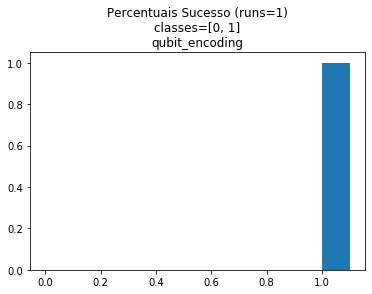

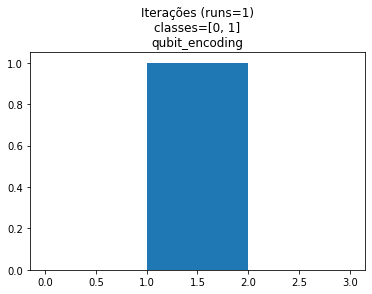

In [3]:
%matplotlib inline

import time
import math as m
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import rand
from sklearn import datasets
from qiskit import(
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram

def loss(label, expectation_value):
    return (1 - (2*label-1) * (2*expectation_value-1)) / 2

def qubit_encoding(circuit, q, classical_data):
    '''
    Codifica a informação clássica no estado inicial usando o operador RY.
    '''
    for i in range(len(classical_data)):
        #circuit.ry(classical_data[i]*m.pi, q[i])
        circuit.ry((2*classical_data[i]-1)*m.pi, q[i])

def amplitude_encoding(circuit, q, classical_data):
    data = (2*classical_data-1)
    desired_vector = data+[0]*(2**len(q)-len(classical_data))
    desired_vector = desired_vector / np.linalg.norm(desired_vector)
    
    circuit.initialize(desired_vector, q)

def mry(circuit, q, params):
    '''
    mry = Multiple RY.
    Função recursiva.
    Aplica a porta RY num conjunto de qubits e os conecta usando CNOT.
    '''
    n = len(q)
    i = 0
    while i < n:
        circuit.ry(params[i], q[i])
        i += 1
        if i < n:
            circuit.ry(params[i], q[i])
            circuit.cx(q[i], q[i-1])
            i += 1

def quantum_processing(n, classical_data, params, draw_circuit=False, draw_filename=None):
    '''
    Algorítmo quântico.
    Monta a rede neural quântica para classificar a informação clássica (classical_data).
    '''
    
    q = QuantumRegister(n, "q")
    c = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(q, c)
    
    if (ENCODING == QUBIT_ENCODING):
        qubit_encoding(circuit, q, classical_data)
    else: # AMPLITUDE_ENCODING
        amplitude_encoding(circuit, q, classical_data)

    circuit.barrier() # pylint: disable=no-member

    layer = 0
    while True:
        ops_count = m.ceil(n / 2**layer)

        mry(circuit, q[:n:m.ceil(n / ops_count)], params[layer])
        circuit.barrier() # pylint: disable=no-member

        layer += 1
        if (ops_count <= 1):
            break

    circuit.measure(q[0], c[0]) # pylint: disable=no-member

    simulator = Aer.get_backend('qasm_simulator')
    
    job = execute(circuit, simulator, shots=1024)
    result = job.result()
    counts = result.get_counts(circuit)

    if (draw_circuit):
        circuit.draw(output='latex', filename=draw_filename).show()
    
    if not('0' in counts):
        counts['0'] = 0
    if not('1' in counts):
        counts['1'] = 0

    return counts

def load_normalized_breast_cancer_set(training_set_size, test_set_size, desired_targets):
    data = datasets.load_breast_cancer()

    data_normed = data.data / data.data.max(axis=0) # pylint: disable=no-member

    randomized = np.array([ [*e[0][:8], e[1]] for e in list(zip(data_normed, data.target))])[np.random.choice(len(data_normed), size=len(data_normed),replace=False), :] # pylint: disable=no-member

    randomized0 = np.array([e for e in randomized if e[len(e)-1] == desired_targets[0] ])
    randomized1 = np.array([e for e in randomized if e[len(e)-1] == desired_targets[1] ])
    
    training_data = np.concatenate((randomized0[:m.ceil(training_set_size/2)], randomized1[:m.ceil(training_set_size/2)]))
    randomized0 = np.delete(randomized0, range(m.ceil(training_set_size/2)), axis=0)
    randomized1 = np.delete(randomized1, range(m.ceil(training_set_size/2)), axis=0)

    test_data = np.concatenate((randomized0, randomized1))
    if (test_set_size < len(test_data)):
        test_data = test_data[:test_set_size]

    return training_data[np.random.choice(len(training_data),len(training_data),replace=False), :], test_data[np.random.choice(len(test_data),len(test_data),replace=False), :]

def load_normalized_iris_set(training_set_size, test_set_size, desired_targets):
    ''' 
    Obtenção dos dados IRIS.
    Os dados clássicos devem ser reescalados para o intervalo [0, pi].
    '''
    iris = datasets.load_iris()
    
    iris_data_normed = iris.data / iris.data.max(axis=0) # pylint: disable=no-member

    randomized = np.array([ [*e[0], e[1]] for e in list(zip(iris_data_normed, iris.target))])[np.random.choice(len(iris_data_normed), size=len(iris_data_normed),replace=False), :] # pylint: disable=no-member

    randomized0 = np.array([e for e in randomized if e[4] == desired_targets[0] ])
    randomized1 = np.array([e for e in randomized if e[4] == desired_targets[1] ])
    
    training_data = np.concatenate((randomized0[:m.ceil(training_set_size/2)], randomized1[:m.ceil(training_set_size/2)]))
    randomized0 = np.delete(randomized0, range(m.ceil(training_set_size/2)), axis=0)
    randomized1 = np.delete(randomized1, range(m.ceil(training_set_size/2)), axis=0)

    test_data = np.concatenate((randomized0, randomized1))
    if (test_set_size < len(test_data)):
        test_data = test_data[:test_set_size]

    return training_data[np.random.choice(len(training_data),len(training_data),replace=False), :], test_data[np.random.choice(len(test_data),len(test_data),replace=False), :]

def initialize_unitary_parameters(n):
    parameters = []
    
    layer = 0
    while True:
        ops_count = m.ceil(n / 2**layer)

        parameters.append([ (2*i-1) * m.pi for i in rand(ops_count)])

        layer += 1
        if (ops_count <= 1):
            break

    return parameters

def gradient_vector(n, classical_data, params, label):
    e = 0.1*m.pi
    grad_vector = [row[:] for row in params]
    for i in range(len(params)):
        for j in range(len(params[i])):
            parm = params[i][j]

            params[i][j] = parm + e
            counts = quantum_processing(n, classical_data, params)
            expectation_value_1 = (counts['1'] / (counts['0'] + counts['1']))

            params[i][j] = parm - e
            counts = quantum_processing(n, classical_data, params) 
            expectation_value_2 = (counts['1'] / (counts['0'] + counts['1']))

            params[i][j] = parm

            # Estimativa de segunda ordem ( O(e^2) ) para a derivada da função loss.
            grad_vector[i][j] = (loss(label, expectation_value_1) - loss(label, expectation_value_2))/(2*e)

    return grad_vector

def learn(rate, params, grad_vector, loss):
    flat_grad_vector = [item for sublist in grad_vector for item in sublist]
    inner_grad = np.inner(flat_grad_vector, flat_grad_vector)
    #log(0, 'loss:', loss, '; inner_grad:', inner_grad)

    for i in range(len(params)):
        for j in range(len(params[i])):
            parameter = params[i][j]
            grad = grad_vector[i][j]
            
            if (grad != 0):
                params[i][j] = parameter - (rate*grad*loss/inner_grad)
    
def log(level, *values, end='\n'):
    if level >= VERBOSE:
        print(*values, end=end)

VERBOSE            = 1
QUBIT_ENCODING     = 0
AMPLITUDE_ENCODING = 1
ENCODING_STRING = {QUBIT_ENCODING : 'qubit_encoding', AMPLITUDE_ENCODING : 'amplitude_encoding'}

ENCODING = QUBIT_ENCODING

def main():
    training_set_size = 30
    batch_size = 2
    test_set_size = 1000
    desired_targets = [0,1]
    measure_probability_threshold = 0.5
    training_loss_threshold = 0.075 # 1/512
    validating_loss_threshold = 0.3
    learn_rate = 1.0
    runs = 1
    max_learn_iters = 2
    max_batch_iters = 12

    identification_rate = np.zeros(runs)
    iterations_rate = np.zeros(runs)

    reset_count = 0
    run = 0
    while run < runs:
        run += 1
        #log(0, 'Learn: ', run)

        #training_set, test_set = load_normalized_breast_cancer_set(training_set_size, test_set_size, desired_targets)
        training_set, test_set = load_normalized_iris_set(training_set_size, test_set_size, desired_targets)

        n = len(training_set[0])-1
        if (ENCODING == AMPLITUDE_ENCODING):
            n = m.ceil(m.log2(n))

        for i in range(n):
            if (2**i >= n):
                n = 2**i
                break

        unitary_parameters = initialize_unitary_parameters(n)

        draw_circuit = False
        start_time = time.time()
        learn_iters = 0
        learned = False
        while not learned and learn_iters < max_learn_iters:
            learn_iters += 1
            #log(0, 'Learn: ', run, ' Iter: ', learn_iters)
        
            for i in range(int(len(training_set)/batch_size)):
                #log(0, 'Learn: ', run, ' Iter: ', learn_iters, ' Batch: ', i+1)
                
                batch_learned = False
                batch_iters = 0
                while not batch_learned and batch_iters < max_batch_iters:
                    batch_iters += 1
                    log(0, 'Learn: ', run, ' Iter: ', learn_iters, ' Batch: ', i+1, ' Iter: ', batch_iters)

                    batch_learned = True
                    for data in training_set[i*batch_size:(i+1)*batch_size]:
                        counts = quantum_processing(n, data[0:-1], unitary_parameters, draw_circuit=draw_circuit)
                        draw_circuit = False

                        target_index = desired_targets.index(data[-1])
                        expectation_value = (counts['1'] / (counts['0'] + counts['1']))
                        
                        l = loss(target_index, expectation_value)

                        if (l > training_loss_threshold):
                            log(0, 'learning...')
                            batch_learned = False
                            grad_vector = gradient_vector(n, data[0:-1], unitary_parameters, target_index)
                            learn(learn_rate, unitary_parameters, grad_vector, l)

                    #if (batch_learned):

                learned = True
                log(0, 'validating...')
                for data in training_set:
                    counts = quantum_processing(n, data[0:-1], unitary_parameters)
                    
                    target_index = desired_targets.index(data[-1])
                    expectation_value = (counts['1'] / (counts['0'] + counts['1']))
                    
                    l = loss(target_index, expectation_value)
                    
                    if (l > validating_loss_threshold):
                        learned = False
                        break

                if (learned):
                    break

        if (not learned):
            log(1, 'Learn iterations limit: ', max_learn_iters)
            # run -= 1
            reset_count += 1
            # continue

        log(0, 'testing...')
        ok_count = 0
        for data in test_set:
            counts = quantum_processing(n, data[0:-1], unitary_parameters)
            
            target_index = desired_targets.index(data[-1])
            probability = (counts[str(target_index)] / (counts['0'] + counts['1']))
                        
            log(0, "\tTgt:", desired_targets[target_index], " Cnt:", counts, end='')
            if (probability > measure_probability_threshold):
                log(0, " OK :", '%.2f' % (probability), "%")
                ok_count += 1
            else:
                log(0, " ERR:", '%.2f' % (probability), "%")
        
        elapsed_time = time.time() - start_time

        iterations_rate[run-1] = learn_iters
        identification_rate[run-1] = ok_count / len(test_set)

        log(1, '\nRun            : ', run)
        log(1, 'Codificação    : ', ENCODING_STRING[ENCODING])
        log(1, 'Iterações      : ', learn_iters)
        log(1, 'Acertos        : ', ok_count)
        log(1, 'Erros          : ', len(test_set) - ok_count)

        log(1, 'Taxa de Acertos: ', ok_count / len(test_set))

        log(1, 'Parâmetros     : ')
        layer = 0
        for i in unitary_parameters:
            layer += 1 
            log(1, 'Camada ', layer, '     : ', i)

        log(10, run,';',ENCODING_STRING[ENCODING],';',len(training_set),';',len(test_set),';',learn_iters,';',ok_count, ';', start_time, ';', elapsed_time)

    log(10, 'Reset count : ', reset_count)

    plt.hist(identification_rate, bins=np.arange(0, 1.2, 0.10))
    plt.title("Percentuais Sucesso (runs=" + str(runs) + ")\nclasses=" + str(desired_targets) + "\n"  + ENCODING_STRING[ENCODING])
    plt.show()

    plt.hist(iterations_rate, bins=np.arange(0, max_learn_iters+2, 1))
    plt.title("Iterações (runs=" + str(runs) + ")\nclasses=" + str(desired_targets) + "\n"  + ENCODING_STRING[ENCODING])
    plt.show()

if __name__ == "__main__":
    main()

## Implementação: MERA

<img src=files/mera.png style="width:35%;float:right">

Um outro algortimo possível é o MERA (Multi-scale Entanglement Renormalization Ansatz. O MERA é uma generalização do MPS (matrix product state) com camadas. Ele também pertence à classe de redes tensoriais hierarquicas com seu esquema de tensores em camadas. 

Diferente de TTN, MERA utiliza tensores de 4 indices depois da compressão/projeção dos tensores de 3 indices (motivo matemático?)

MPS apenas captura "exponentially decaying correlations", MERA captura "power-law" correlations. (?)

Fortemente influenciado pela Física.



### Qiskit
Implementação utilizando Python e Qiskit

## Conclusões e Comentários

## Complementos

### Representação
 
Queremos demonstrar que o modelo de rede neural quântica aqui apresentado é capaz de expressar qualquer função de rótulo com dois valores, mesmo que, possivelmente, com um alto custo em termos de profundidade do circuito.

Para n bits, temos $2^n$ strings e, portanto, $2^{(2^n)}$ possíveis funções de rótulo $l(z)$. Dada uma função de rótulo, considere o operador cuja ação é definida nos estados da base computacional como

$
U_l \left|z, z_{n+1}\right\rangle = e^{i \frac{\pi}{4} l(z) X_{n+1}} \left|z,z_{n+1}\right\rangle
$

que é a rotação de $\frac{\pi}{4}$ do qubit de saída ($z_{n+1}$) sobre o eixo $x$. De maneira equivalente

$
U_l^\dagger Y_{n+1} U_l = \left( e^{-i \frac{\pi}{4} l(z) X_{n+1}} \right) Y_{n+1} \left( e^{i \frac{\pi}{4} l(z) X_{n+1}} \right) \\
=\left[ cos \left(\frac{\pi}{4}l(Z) \right)I - i sen \left(\frac{\pi}{4}l(Z) \right)X_{n+1} \right] Y_{n+1} \left[ cos \left(\frac{\pi}{4}l(Z) \right)I + i sen \left(\frac{\pi}{4}l(Z) \right)X_{n+1} \right] \\
=cos \left(\frac{\pi}{2}l(Z) \right)Y_{n+1} + sen \left(\frac{\pi}{2}l(Z) \right)Z_{n+1}
$

onde $l(Z)$ é um operador diagonal na base computacional. Sabendo que $l(z)=+1, -1$, podemos mostrar que

$
\left\langle z,1\right| U_l^\dagger Y_{n+1} U_l \left|z,1\right\rangle 
=cos \left(\frac{\pi}{2}l(Z) \right)\left\langle z,1\right| Y_{n+1}\left|z,1\right\rangle + sen \left(\frac{\pi}{2}l(Z) \right) \left\langle z,1\right| Z_{n+1}\left|z,1\right\rangle \\
=sen \left(\frac{\pi}{2}l(Z) \right) \left\langle z,1\right| Z_{n+1}\left|z,1\right\rangle \\
=l(z)
$

Vemos então, de maneira abstrata, que temos uma forma de representar qualquer rótulo através de um circuito quântico.

Vamos agora explicar como escrever $U_l$ como um produto de uma operação unitária em dois qubits. Para esta discussão é conveniente mudarmos para variáveis Booleanas $b_i=\frac{1}{2}(1-z_i)$ e pensar em nossa função de rótulo $l$ como $1-2b$, onde $b$ é 0 ou 1. Podemos agora usar a representação de Reed-Muller para uma função Booleana em termos dos bits $b_1$ a $b_n$:

$
b=a_0\oplus (a_1 b_1 \oplus a_2 b_2 \oplus \dotsb a_n b_n)\oplus (a_{12} b_1 b_2 \oplus a_{13} b_1 b_3\oplus \dotsb)\oplus \dotsb \oplus a_{123} \dotsb b_1 b_2\dotsb b_n .
$

A adição é mod2 e os coeficiente $a$ são todos 0 ou 1. Perceba que há $2^n$ coeficientes e, sendo todos 0 ou 1, vemos que efetivamente que há $2^{(2^n)}$ funções Booleanas sendo representadas. A fórmula pode ser exponenciamente longa. Agora podemos escrever a operação unitária dependente da função de rótulo como:

$
U_l 
=e^{i \frac{\pi}{4}l(z)X_{n+1}} \\
=e^{i \frac{\pi}{4}(1-2B)X_{n+1}} \\
=e^{i \frac{\pi}{4}X_{n+1}}e^{-i \frac{\pi}{2} B X_{n+1}}
$

onde $B$ é o operador, diagonal na base computacional, correspodente a $b$. Cada termo de $B$ é multiplicado por $X_{n+1}$ e, portanto, cada termo comuta com os outros. Cada termos não nulo na fórmula de Reed-Muller dá origem em $U_l$ a um bit flip (NOT) controlado no qubit de saída. Para ver isso, considere o termo de três bits envolvendo os bits 2, 7 e 9. Ele corresponde ao operador

$
e^{-i\frac{\pi}{2}B_2 B_7 B_9 X_{n+1}}
$

o qual, agindo num estado da base computacional nos primeiros n qubits, é a identidade, a menos que $b_2=b_7=b_9=1$ quando é $-i X_{n+1}$. É conhecido de outros trabalhos [11] que qualquer operação unitária controlada atuando no qubit $n+1$, onde o controle é feito pelos primeiros n qubits, pode ser escrito como um produto de $n^2$ operações unitárias em dois qubits. Portanto, qualquer função de rótulo expressa em termos da fórmula de Reed-Muller com M termos pode ser escrita como o produto de operadores unitários, que comutam, em $n+1$ qubits, e cada um deles pode ser escrito com $n^2$ operações unitárias em dois qubits.